# Alpha Vantage Data Analysis
An analysis of stock data from Alpha Vantage. Below, a specific stock is chosen.

In [1]:
ticker = 'AAPL'

Now, data is donwloaded for the stock and saved. Remember that Alpha Vantage has a limited amount of calls per day and minute!

In [3]:
import save_data_to_csv

save_data_to_csv.save_dataset(ticker)

## Adjusted Price and Volume Graphs
The data is imported from where it is saved and plotted.

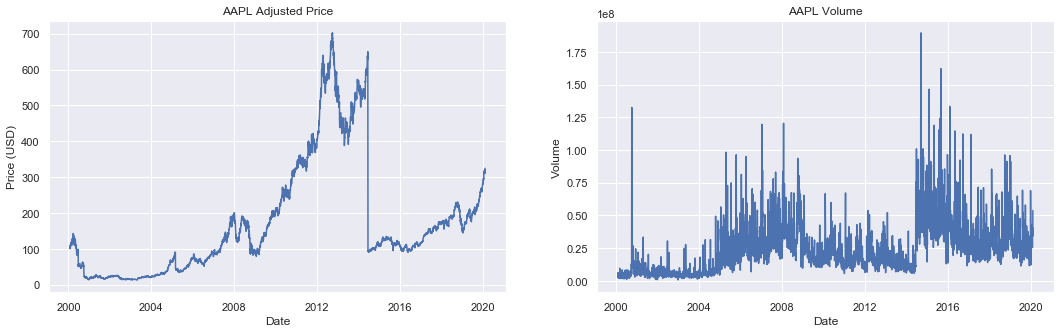

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get data and make a datetime index
data = pd.read_csv(f'./Stock Data/{ticker}_daily_adjusted.csv')
data.set_index(pd.to_datetime(data['date']), inplace=True)
data.drop(columns='date', inplace=True)

# Make graphs
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

ax[0].plot(data.index, data.loc[:, '1. open'])
ax[0].set_title(ticker + ' Adjusted Price')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price (USD)')

ax[1].plot(data.index, data.loc[:, '6. volume'])
ax[1].set_title(ticker + ' Volume')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Volume');

## Technical Indicators
Techincal indicators are downloaded.

In [6]:
import save_ti_to_csv

save_ti_to_csv.save_ti(ticker)

Tehnical indicators are added to the data and plotted.

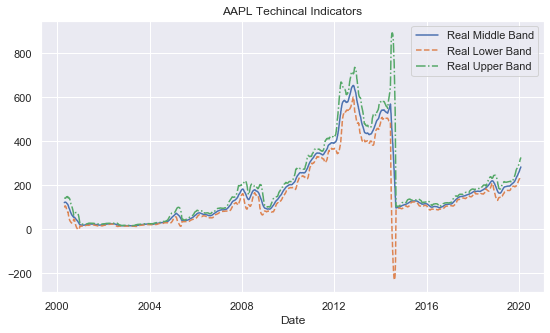

In [53]:
# Technical indicators added
ti = pd.read_csv(f'./Stock Data/{ticker}_daily_ti.csv')
ti.set_index(pd.to_datetime(ti['date']), inplace=True)
ti.drop(columns='date', inplace=True)
data = data.join(ti, on='date').dropna()
data.sort_index(inplace=True)

# Technical indicators plotted
plt.figure(figsize=(9, 5))
plt.plot(data.index, data['Real Middle Band'], label='Real Middle Band')
plt.plot(data.index, data['Real Lower Band'], label='Real Lower Band',
         linestyle='--')
plt.plot(data.index, data['Real Upper Band'], label='Real Upper Band',
         linestyle='-.')
plt.xlabel('Date')
plt.title(ticker + ' Techincal Indicators')
plt.legend();

## Predictive Modeling
Here, preditive modeling is perfromed on the data.
### Preprocessing
The data is preprocessed.

In [55]:
from sklearn.preprocessing import Normalizer
import numpy as np

# Number of historical points needed to make next prediction
hist_num = 50

# Get data in an array without dates
X = data.sort_index().values

# Normalize data
X = Normalizer().fit_transform(X)

# Get data ready for model. Model should make a predicton based on 50 observations.
y = np.array([data.iloc[:, 4][i + hist_num] for i in range(data.shape[0] - hist_num)])
y = np.expand_dims(y, -1)
X = np.array([X[i:i+hist_num] for i in range(X.shape[0] - hist_num)])

# Make sure we have the same amount of labels as observations
assert(y.shape[0] == X.shape[0])

# Split data into testing and training
test_perc = .2
n = int(X.shape[0]*(1 - test_perc))
Xtrain = X[:n]
Xtest = X[n:]
ytrain = y[:n]
ytest = y[n:]

### Modeling
A LSTM nerual network is trained.

In [64]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout,\
LSTM, Input, Activation, concatenate
from keras import optimizers
np.random.seed(4)
from tensorflow import set_random_seed
set_random_seed(4)
from keras.callbacks import EarlyStopping

# Build model
lstm_input = Input(shape=(hist_num, X.shape[2]), name='lstm_input')
x = LSTM(hist_num, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

# Train model
es = EarlyStopping('val_loss')
fit = model.fit(x=Xtrain, y=ytrain, batch_size=32, epochs=50,
          shuffle=True, validation_split=0.1, callbacks=[es]);

Train on 3545 samples, validate on 394 samples
Epoch 1/50
3545/3545 [==============================] - 23s 7ms/step - loss: 1016.0468 - val_loss: 9759.0352
Epoch 2/50
3545/3545 [==============================] - 14s 4ms/step - loss: 847.5225 - val_loss: 9242.5108
Epoch 3/50
3545/3545 [==============================] - 12s 3ms/step - loss: 782.9010 - val_loss: 8841.6464
Epoch 4/50
3545/3545 [==============================] - 11s 3ms/step - loss: 737.5081 - val_loss: 8495.8062
Epoch 5/50
3545/3545 [==============================] - 11s 3ms/step - loss: 704.3567 - val_loss: 8206.8720
Epoch 6/50
3545/3545 [==============================] - 12s 3ms/step - loss: 680.5187 - val_loss: 7951.9636
Epoch 7/50
3545/3545 [==============================] - 13s 4ms/step - loss: 663.6397 - val_loss: 7734.3933
Epoch 8/50
3545/3545 [==============================] - 13s 4ms/step - loss: 651.6049 - val_loss: 7554.8707
Epoch 9/50
3545/3545 [==============================] - 13s 4ms/step - loss: 643.7240 - 

Here is a visualization of the fit history.

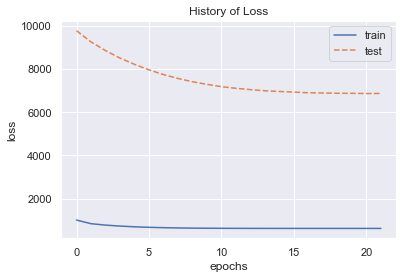

In [65]:
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], '--', label='test',)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('History of Loss')
plt.legend();

### Evaluation
The model is evaluated on the test data.

In [66]:
evaluation = model.evaluate(Xtest, ytest)
print(f'The evaluation score is {evaluation}.')

985/985 [==============================] - 1s 722us/step
The evaluation score is 22479.382225571066.


Now we plot the predicted price next to the actual.

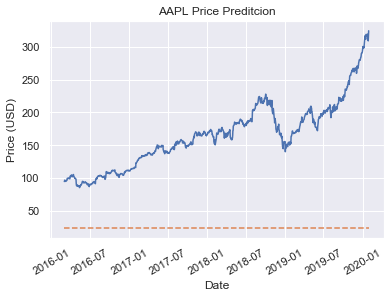

In [67]:
# Predict
ypred = model.predict(Xtest)

# Graph
plt.plot(data.index[n+hist_num:], ytest, label='Actual Price')
plt.plot(data.index[n+hist_num:], ypred, '--',
         label='Predicted Price')
plt.title(ticker + " Price Preditcion")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=30);